<center><b> In this notebook, I have implemented and trained a DCGAN from scratch so as to generate realistic anime pictures
    
<hr>

## Importing Libraries 

In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')

import keras
from tensorflow.keras.optimizers.legacy import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose

from tensorflow.compat.v1.keras.layers import BatchNormalization

Next, create all the necessary functions that will be used for loading the data.






In [2]:
def list_images(basePath, contains=None):
    validExts = (".jpg")
    for rootDir, dirNames, filenames in os.walk(basePath):
        for filename in filenames:
            if contains is not None and contains not in filename:
                continue
            ext = filename[filename.rfind("."):].lower()
            if ext in validExts:
                yield os.path.join(rootDir, filename)

def load_images(directory='', size=(64, 64)):
    images = []
    
    for path in list_images(directory):
            image = cv2.imread(path)
            image = cv2.resize(image, size)
            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    return images

In [3]:
images=load_images('../input/animefacedataset/images/')

## Looking at some images

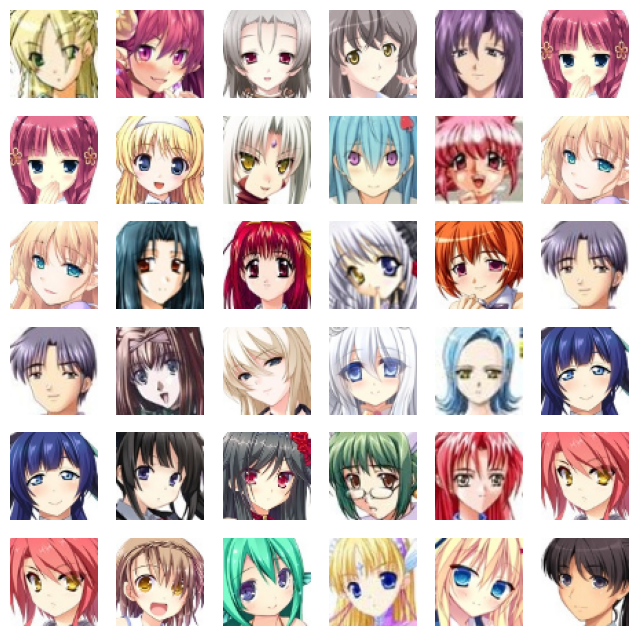

In [4]:
_, axes = plt.subplots(6,6, figsize=(8,8))
for i in range(6):
    for j in range(6):
        axes[i, j].imshow(images[5 * i + j])
        axes[i, j].axis('off')
plt.show()

## Generative Adversarial Networks

The goal of a Generative Adversarial Network (GAN) is to teach a data generator to replicate a specific dataset.

A GAN operates like a zero-sum game involving two neural networks: the data generator and a discriminator. The generator aims to produce data that mimics the original dataset, while the discriminator is trained to differentiate genuine data from the artificially generated data created by the generator. This competitive dynamic between the two networks drives the training process of the GAN.

<img src="https://www.researchgate.net/profile/Jose-Benitez-Andrades/publication/339447623/figure/fig2/AS:862056077082627@1582541593714/A-vanilla-Convolutional-Neural-Network-CNN-representation.png" width="800px">

During each training step, the discriminator is exposed to a batch of data that includes both real and fake images. It learns to distinguish between genuine and generated images. Subsequently, the generator is trained to produce a batch of artificial images that can hopefully fool the discriminator.


In a Deep Convolutional Generative Adversarial Network (DCGAN), the data generator typically has the following structure:

<img src="https://pytorch.org/tutorials/_images/dcgan_generator.png" width="800px">

In a DCGAN, the input noise vector adds diversity to the generated images. As training progresses, each dimension of this vector corresponds to different image features, allowing precise control over the output characteristics, such as hair shape or clothing texture.

To summarize-<br>

<img src="https://www.researchgate.net/publication/343597759/figure/fig4/AS:923532934529034@1597198818441/The-architecture-of-the-generator-and-the-discriminator-in-a-DCGAN-model-FSC-is-the.ppm" width="800px">







# Creating DCGAN Architecture

In [5]:
class DCGAN():
    def __init__(self):
        self.img_shape = (64, 64, 3)
        
        self.noise_size = 128

        optimizer = Adam(0.0002,0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        
        self.discriminator.trainable = False
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined.summary()
        
    # Creating the generator, the large kernels in the convolutional layers allow the network to create complex structures.
    def build_generator(self):
        epsilon = 0.00001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
        noise_shape = (self.noise_size,)
        
        model = Sequential()
        
        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))
        
        model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))

        # Standard activation for the generator of a GAN
        model.add(Activation("tanh"))
        
        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, metrics_update=50, save_images=100, save_model=2000):

        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)
        
        mean_d_loss=[0,0]
        mean_g_loss=0

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)

            # Training the discriminator
            
            # The loss of the discriminator is the mean of the losses while training on authentic and fake images
            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            # Training the generator
            for _ in range(2):
                noise = np.random.normal(0, 1, (batch_size, self.noise_size))

                valid_y = np.array([1] * batch_size)
                g_loss = self.combined.train_on_batch(noise, valid_y)
            
            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss
            
            # We print the losses and accuracy of the networks every 200 batches mainly to make sure the accuracy of the discriminator
            # is not stable at around 50% or 100% (which would mean the discriminator performs not well enough or too well)
            if epoch % metrics_update == 0:
                print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/metrics_update, 100*mean_d_loss[1]/metrics_update, mean_g_loss/metrics_update))
                mean_d_loss=[0,0]
                mean_g_loss=0
            
            # Saving 25 images
            if epoch % save_images == 0:
                self.save_images(epoch)
            
            # We save the architecture of the model, the weights and the state of the optimizer
            # This way we can restart the training exactly where we stopped
            if epoch % save_model == 0:
                self.generator.save("generator_%d" % epoch)
                self.discriminator.save("discriminator_%d" % epoch)

    # Saving 25 generated images to have a representation of the spectrum of images created by the generator
    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        
        # Rescale from [-1,1] into [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5,5, figsize = (8,8))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()
        
        fig.savefig("anime_DCGAN/Train_%d.png" % epoch)
        plt.close()

## Training DCGAN

We will make a folder so as to contain the images generated during the training

In [6]:
!mkdir anime_DCGAN

# Training the Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                        

2023-11-03 16:15:35.647807: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-03 16:15:37.795783: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/model/sequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


0 [Discriminator loss: 0.028411, acc.: 0.17%] [Generator loss: 0.000234]
1/1 [==============================] - 0s 223ms/step


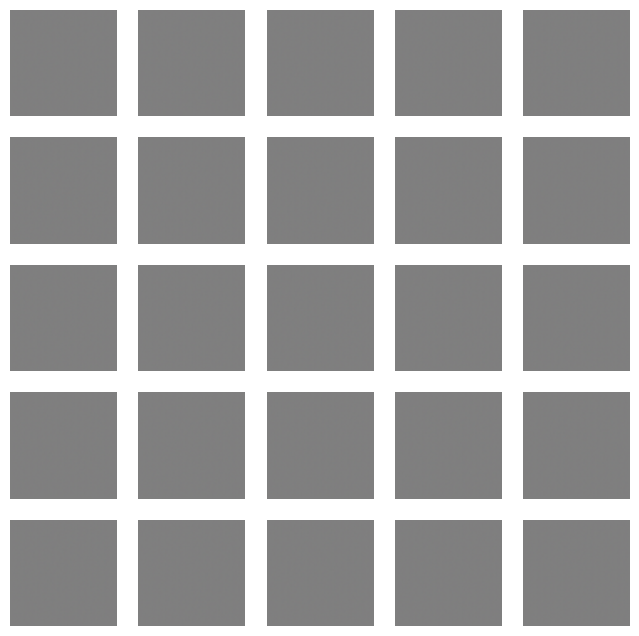

2/2 [==============================] - 0s 9ms/step
200 [Discriminator loss: 0.634832, acc.: 69.55%] [Generator loss: 1.643095]
2/2 [==============================] - 0s 9ms/step
400 [Discriminator loss: 0.701308, acc.: 56.45%] [Generator loss: 1.240280]
2/2 [==============================] - 0s 9ms/step
600 [Discriminator loss: 0.674177, acc.: 58.82%] [Generator loss: 1.181646]
2/2 [==============================] - 0s 9ms/step
800 [Discriminator loss: 0.644916, acc.: 62.65%] [Generator loss: 1.369440]
2/2 [==============================] - 0s 9ms/step
1000 [Discriminator loss: 0.663156, acc.: 59.97%] [Generator loss: 1.263030]
2/2 [==============================] - 0s 9ms/step
1200 [Discriminator loss: 0.672644, acc.: 58.79%] [Generator loss: 1.248021]
2/2 [==============================] - 0s 9ms/step
1400 [Discriminator loss: 0.661490, acc.: 60.46%] [Generator loss: 1.311349]
2/2 [==============================] - 0s 9ms/step
1600 [Discriminator loss: 0.646875, acc.: 62.11%] [Genera

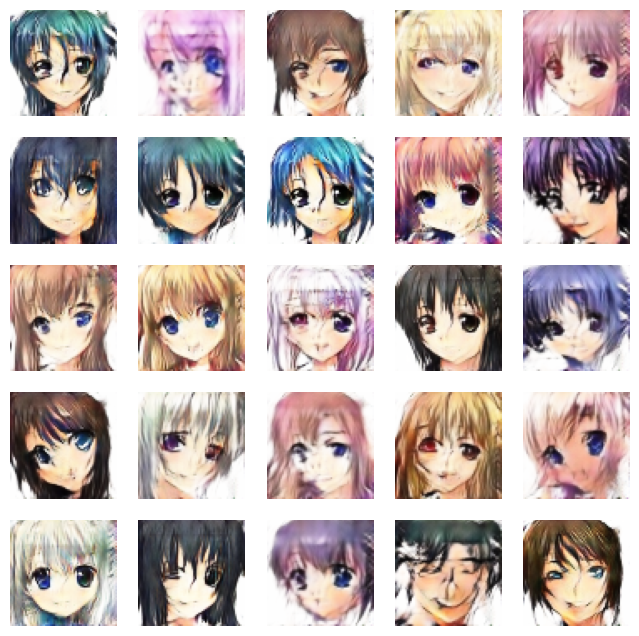

2/2 [==============================] - 0s 9ms/step
3200 [Discriminator loss: 0.613790, acc.: 65.92%] [Generator loss: 1.486198]
2/2 [==============================] - 0s 9ms/step


In [ ]:
# Instantiate the DCGAN class and use it to train the model
dcgan = DCGAN()
dcgan.train(epochs=15001, batch_size=128, metrics_update=200, save_images=3000, save_model=15000)